In [1]:
user_name = str(input("Enter Your Name: "))
print(user_name)

sachin


In [6]:
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora

# Load dataset
meetingbank = load_dataset("huuuyeah/meetingbank")
train_data = meetingbank["train"]
train_data = train_data.select(range(1000))
# Collect transcripts
texts = [word_tokenize(d["transcript"].lower()) for d in train_data]

# Remove stopwords and short tokens
stop_words = set(stopwords.words("english"))
texts = [[w for w in doc if w.isalpha() and w not in stop_words] for doc in texts]

# Build dictionary & corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [2]:
from gensim.models import LdaModel

num_topics = 5  # change depending on how many themes you expect
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

# Show topics
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.017*"council" + 0.015*"thank" + 0.012*"councilmember" + 0.010*"bill" + 0.008*"committee" + 0.008*"amendment" + 0.008*"would" + 0.007*"city" + 0.006*"please" + 0.006*"item"
Topic 1: 0.014*"know" + 0.012*"think" + 0.011*"would" + 0.010*"going" + 0.008*"one" + 0.008*"right" + 0.007*"thank" + 0.007*"city" + 0.006*"like" + 0.006*"want"
Topic 2: 0.011*"thank" + 0.009*"neighborhood" + 0.008*"plan" + 0.007*"council" + 0.007*"area" + 0.007*"development" + 0.007*"district" + 0.007*"would" + 0.006*"one" + 0.006*"housing"
Topic 3: 0.022*"thank" + 0.009*"know" + 0.008*"people" + 0.008*"city" + 0.008*"council" + 0.006*"one" + 0.006*"community" + 0.006*"denver" + 0.006*"want" + 0.006*"councilman"
Topic 4: 0.014*"city" + 0.012*"know" + 0.012*"thank" + 0.011*"think" + 0.010*"would" + 0.008*"want" + 0.008*"going" + 0.007*"long" + 0.007*"council" + 0.006*"one"


In [7]:
import nltk
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

# 1. Extract sentences from transcripts
sentences = []
for transcript in train_data["transcript"]:
    for sent in sent_tokenize(transcript):
        sentences.append(sent.strip())

print(f"Total sentences: {len(sentences)}")

# 2. Load a sentence transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")  # small & fast

# 3. Encode sentences into embeddings
embeddings = model.encode(sentences, show_progress_bar=True)

# 4. Cluster sentences with KMeans
num_clusters = 5  # you can tune this number
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(embeddings)
cluster_labels = clustering_model.labels_

# 5. Save results to CSV
df = pd.DataFrame({
    "sentence": sentences,
    "cluster": cluster_labels
})
df.to_csv("sentence_clusters.csv", index=False)

print("✅ Saved clustered sentences to sentence_clusters.csv")


Total sentences: 286028


Batches: 100%|██████████| 8939/8939 [02:24<00:00, 62.01it/s] 


✅ Saved clustered sentences to sentence_clusters.csv


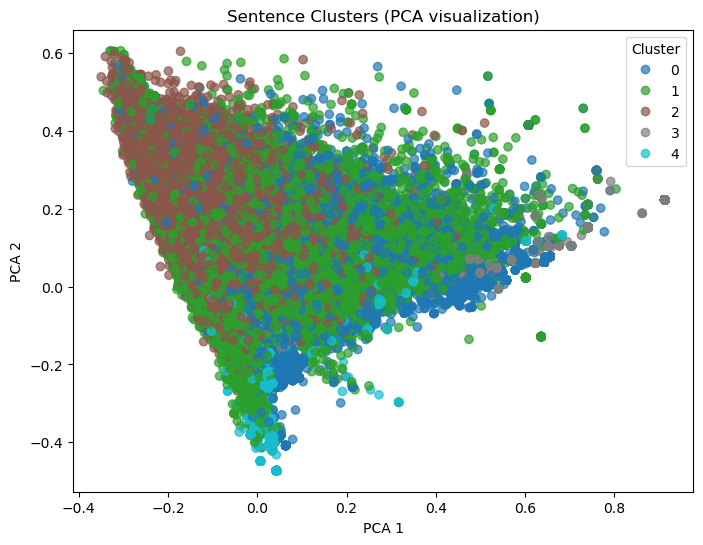

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Load your CSV
df = pd.read_csv("sentence_clusters.csv")  # change to your file path

# Convert sentences into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=200)
X = vectorizer.fit_transform(df["sentence"])

# Reduce to 2D for plotting
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())

# Add PCA coords to dataframe
df["x"] = reduced[:,0]
df["y"] = reduced[:,1]

# Plot clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(df["x"], df["y"], 
                      c=df["cluster"], cmap="tab10", alpha=0.7)

# Add cluster labels in legend
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("Sentence Clusters (PCA visualization)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
import pandas as pd

# Load your CSV
df = pd.read_csv("sentence_clusters.csv")  # change path if needed

# Group by cluster
grouped = df.groupby("cluster")["sentence"].apply(list).reset_index()

# Show nicely
for _, row in grouped.iterrows():
    print(f"\nCluster {row['cluster']} ({len(row['sentence'])} sentences):")
    for sent in row["sentence"]:
        print(f"  - {sent}")
